In [1]:
# !pip install pandas matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import io
import re

In [12]:
df = pd.concat((
    pd.read_csv(f)
    for f in [
        './data/ble-dump/L.csv',
        './data/ble-dump/circle.csv',
    ]
))
df

,ax,ay,az,gx,gy,gz,name,n
0,-1432,525,15991,472,-1752,124,L,0
1,-865,442,16999,206,-1432,85,L,0
2,-53,381,16454,385,-1128,29,L,0
3,-2392,440,15922,391,-570,-403,L,0
4,-43,357,16071,178,-444,-221,L,0
...,...,...,...,...,...,...,...,...
670,-1297,-4485,22623,6121,2866,-1458,circle,7
671,-1367,-4637,23628,7341,1899,-1307,circle,7
672,-1959,-4419,20240,10185,518,-1113,circle,7
673,-532,-3321,14272,12127,-1269,-462,circle,7


In [7]:
def plot_mov(df, name, n, ax):
    df[
        (df.name == name) & (df.n == n)
    ][['ax', 'ay', 'az', 'gx', 'gy', 'gz']].plot(ax=ax)
    ax.set_title(f'{name} #{n}')

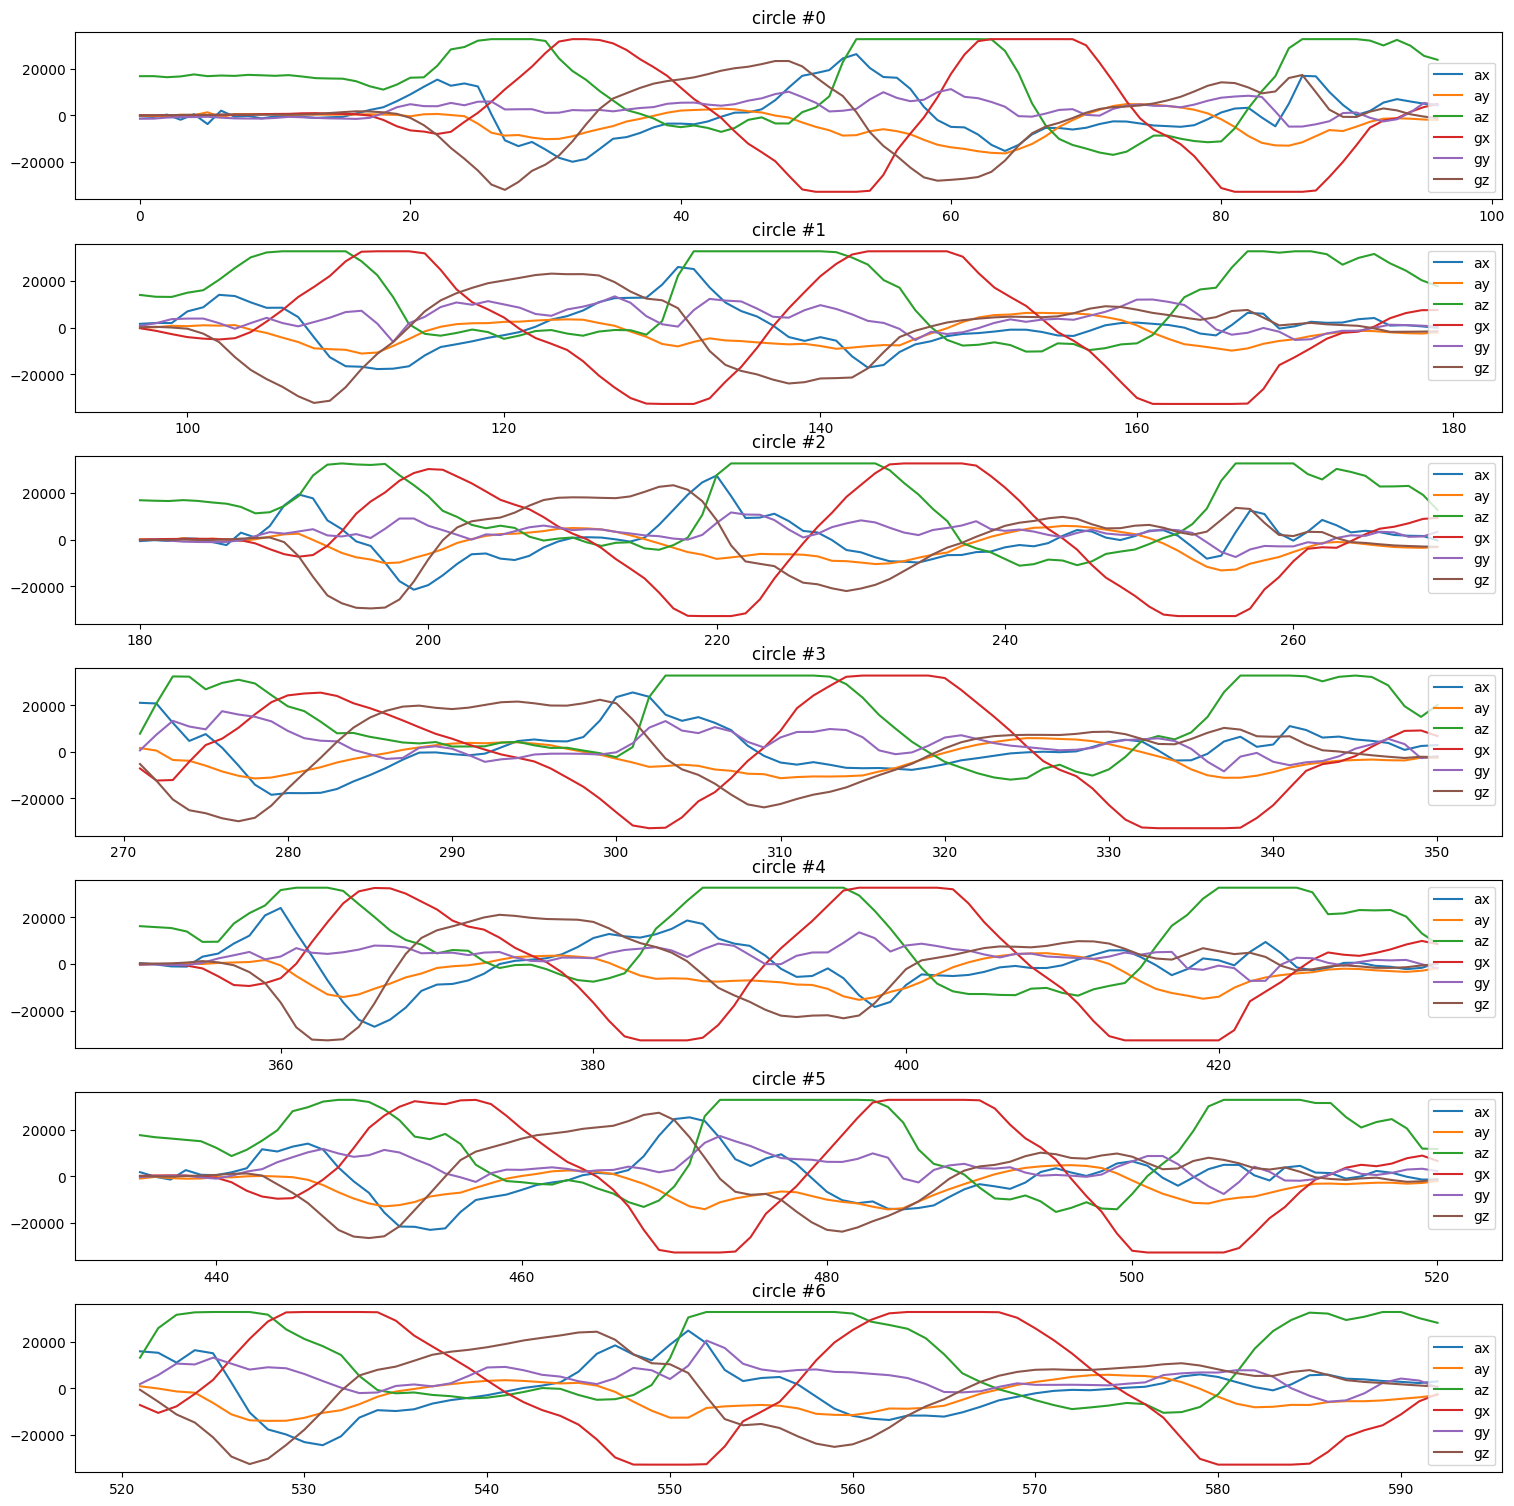

In [14]:
N_EACH = 7

fig, axs = plt.subplots(1 * N_EACH, 1, figsize=(15, 15))
fig.tight_layout()

# for i in range(N_EACH):
#     plot_mov(df, 'L', i, axs[i])

for i in range(N_EACH):
    plot_mov(df, 'circle', i, axs[i])



In [34]:
#!pip install dtw-python
# !pip install seaborn dtw-python

In [15]:
import dtw

# https://dynamictimewarping.github.io/python/

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



Text(0, 0.5, 'z #5')

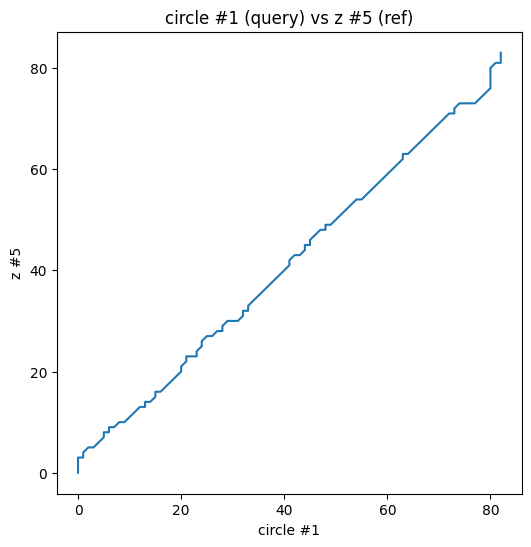

In [20]:
DATA_COLS = ['ax', 'ay', 'az', 'gx', 'gy', 'gz']

def mov_df(df, name, n):
    return df[(df.name == name) & (df.n == n)][DATA_COLS]

res = dtw.dtw(
    # Query.
    mov_df(df, 'circle', 1),
    # Reference.
    mov_df(df, 'circle', 4)
)
ax = res.plot()
ax.set_title('circle #1 (query) vs z #5 (ref)')
ax.set_xlabel('circle #1')
ax.set_ylabel('z #5')

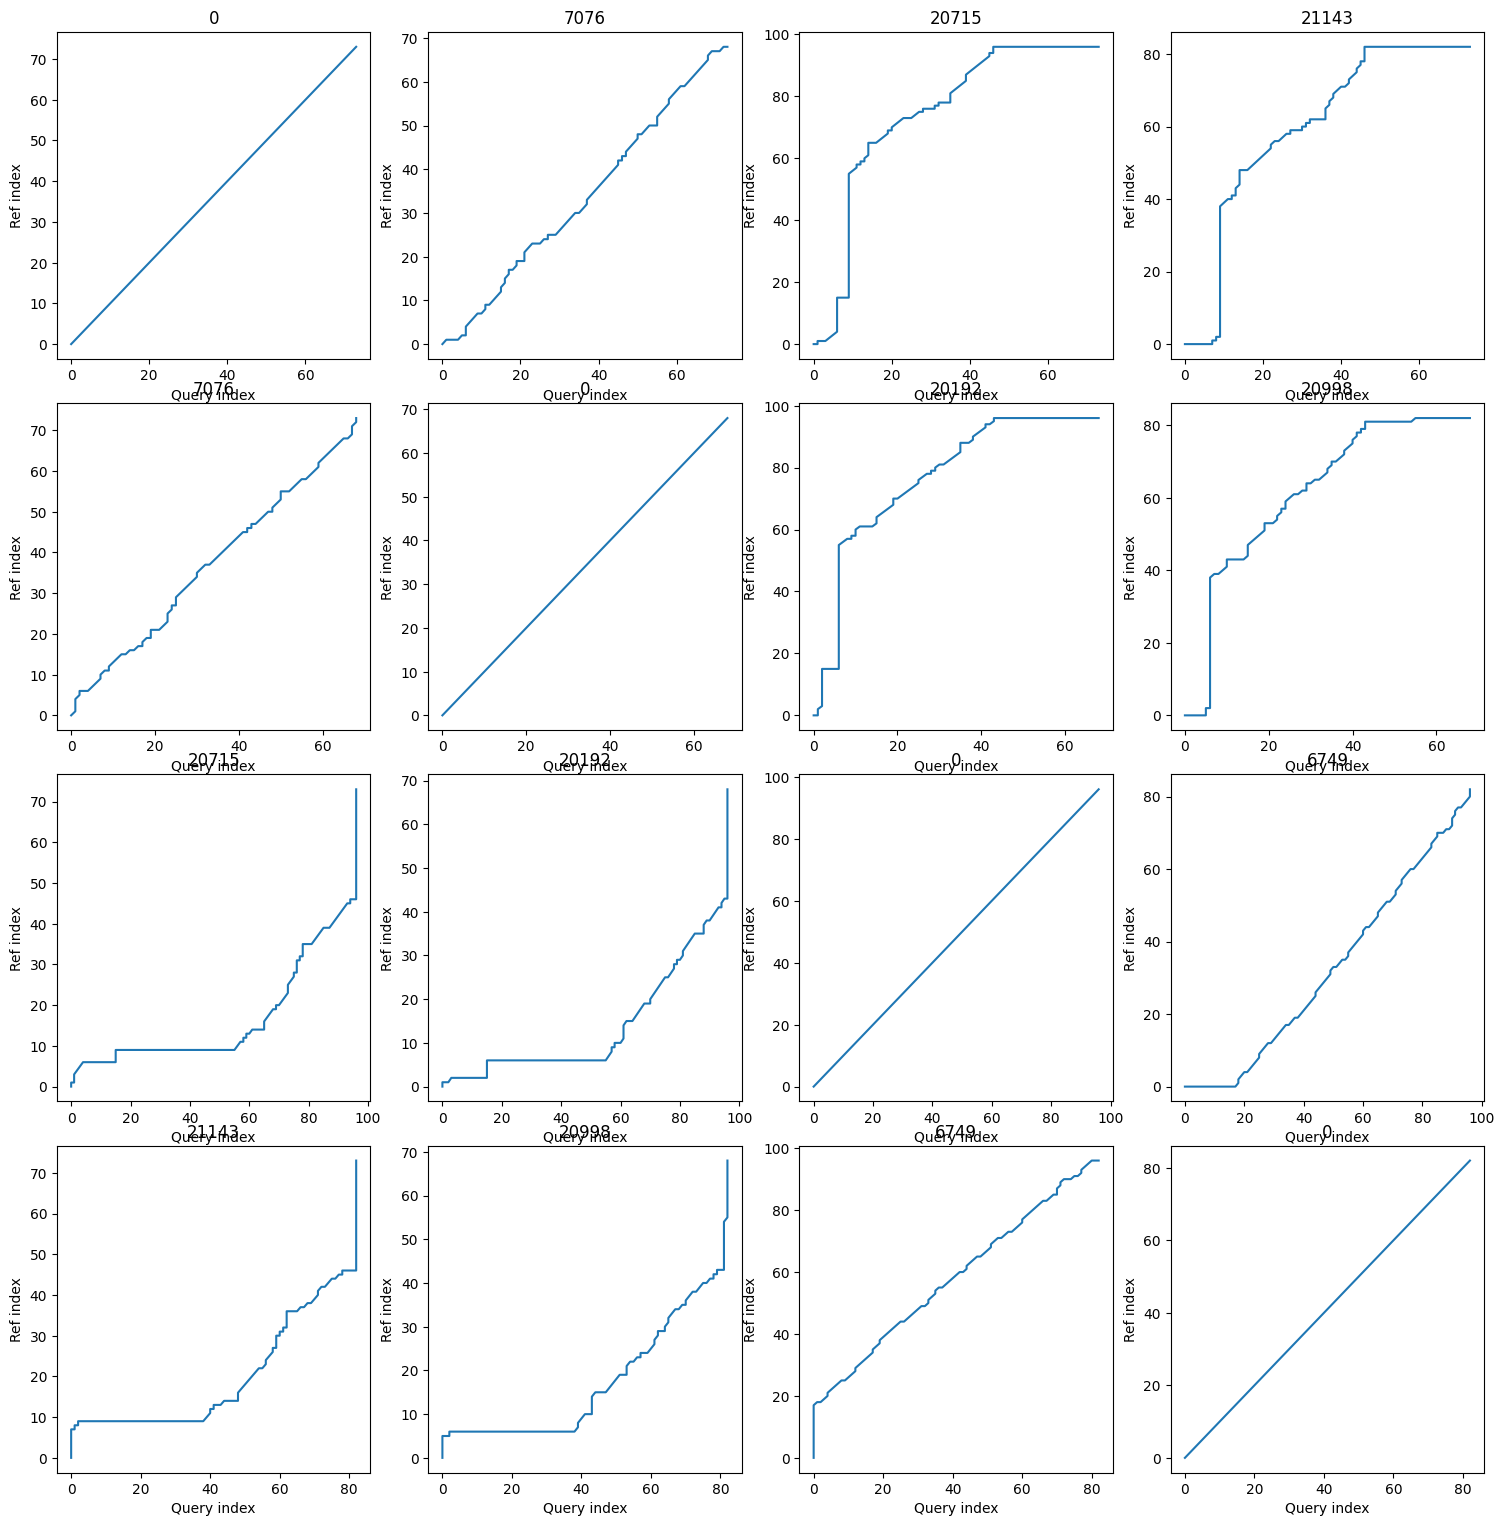

In [21]:
dfs = [mov_df(df, 'L', i) for i in range(2)] + \
      [mov_df(df, 'circle', i) for i in range(2)]
      # [mov_df(df, 'circle', i) for i in range(2)] + \
      # [mov_df(df, 'swipe', i) for i in range(2)]

# [mov_df(df, 'double-circle', i) for i in range(2)] + \

fig, axs = plt.subplots(len(dfs), len(dfs), figsize=(15, 15))
fig.tight_layout()
for i, df1 in enumerate(dfs):
    for j, df2 in enumerate(dfs):
        ax = axs[i][j]
        align = dtw.dtw(df1, df2) 
        # https://github.com/DynamicTimeWarping/dtw-python/blob/56d2e09dd4409f2d7bafb465889d696a25ebdd2c/dtw/dtwPlot.py#L79
        ax.plot(align.index1, align.index2)
        ax.set_xlabel("Query index")
        ax.set_ylabel("Ref index")
        ax.set_title(f'{int(align.normalizedDistance)}')

In [22]:
import itertools

keys = [k for k, v in df.groupby(['name', 'n'])]

# for k1, k2 in itertools.combinations_with_replacement(keys, 2):
#     print(k1, k2)

def k_dist(k1, k2):
    return dtw.dtw(mov_df(df, *k1), mov_df(df, *k2)).normalizedDistance

def name(k):
    s, n = k
    return f'{s}_{n}'

records = [{
    'k1': name(k1),
    'k2': name(k2),
    'dist': k_dist(k1, k2),
    }
    for a, b in itertools.combinations_with_replacement(keys, 2)
    for k1, k2 in [(a, b), (b, a)]
    if k1 != k2
]

dist_matrix = pd.DataFrame.from_records(records)

In [23]:
dist_df = dist_matrix.pivot(index='k1', columns='k2', values='dist').fillna(0.0)

<Axes: xlabel='k2', ylabel='k1'>

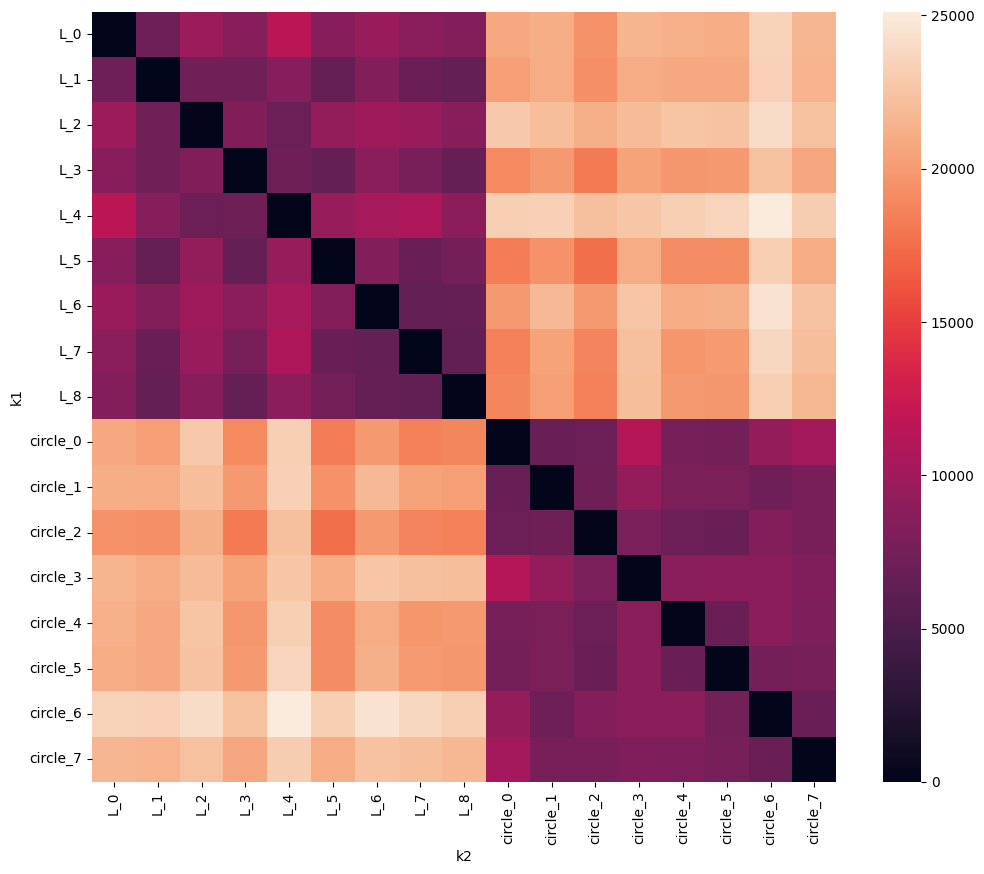

In [24]:
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(12,10))
sns.heatmap(dist_df, ax=ax)

In [53]:
# Which row is the min dist to circle_0?
dist_df.columns[dist_df['circle_0'].argmin()]

'circle_0'